In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word

In [3]:
movies = pd.read_pickle('movies.pkl')

#Replace missing values with actual Python NaN.
movies = movies.replace('N/A', np.NaN)
movies = movies.replace('NA', np.NaN)
movies = movies.replace('NULL', np.NaN)

#Set the imdbRating column as float instead of strings
movies.imdbRating = movies.imdbRating.astype(float)


,title,script,IMDB_info,Actors,imdbID,Awards,Country,Director,Genre,Language,...,Rated,Released,Runtime,Writer,Year,imdbRating,imdbVotes,financials,Budget,Revenue
0,10 Things I Hate About You,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"{u'Plot': u'A pretty, popular teenager can't g...","Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",tt0147800,2 wins & 12 nominations.,USA,Gil Junger,"Comedy, Drama, Romance","English, French",...,PG-13,31 Mar 1999,97 min,"Karen McCullah, Kirsten Smith",1999,7.2,"225,311","[16000000.0, 38176108.0]",16000000.0,38176108.0
1,12,\n\n\n \n 12 - Script\n,{u'Plot': u'Twelve jurors must decide the fate...,"Sergey Makovetskiy, Nikita Mikhalkov, Sergey G...",tt0488478,Nominated for 1 Oscar. Another 5 wins & 5 nomi...,Russia,Nikita Mikhalkov,"Crime, Drama, Thriller","Russian, Chechen",...,PG-13,20 Sep 2007,159 min,"Nikita Mikhalkov, Aleksandr Novototskiy-Vlasov...",2007,7.8,"11,741","[4000000.0, 125024.0]",4000000.0,125024.0
2,12 and Holding,\n \n \n \n ...,{u'Plot': u'After his twin brother is accident...,"Conor Donovan, Jesse Camacho, Zoe Weizenbaum, ...",tt0417385,5 nominations.,USA,Michael Cuesta,Drama,English,...,R,07 Jul 2006,94 min,Anthony Cipriano,2005,7.6,"6,157","[400000.0, 95687.0]",400000.0,95687.0
3,12 Monkeys,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"{u'totalSeasons': u'2', u'Plot': u'Follows the...","Aaron Stanford, Amanda Schull, Kirk Acevedo, B...",tt3148266,2 wins & 2 nominations.,USA,NaN,"Adventure, Drama, Mystery",English,...,TV-14,16 Jan 2015,42 min,"Travis Fickett, Terry Matalas",2015–,7.6,"21,688","[NULL, NULL]",NaN,NaN
4,12 Years a Slave,\n\r\n\r\n\r\n 12 ...,"{u'Plot': u'In the antebellum United States, S...","Chiwetel Ejiofor, Dwight Henry, Dickie Gravois...",tt2024544,Won 3 Oscars. Another 234 wins & 312 nominations.,"USA, UK",Steve McQueen,"Biography, Drama, History",English,...,R,08 Nov 2013,134 min,"John Ridley (screenplay), Solomon Northup (bas...",2013,8.1,"448,530","[20000000.0, 56667870.0]",20000000.0,56667870.0


In [5]:
#Makes a new Data Frame without movies with script missing.
movie_scripts = movies[(movies.script.notnull())].copy()
movie_scripts.reset_index(inplace = True)
del movie_scripts['index']

In [6]:
def sentiment(script, pages = 100, ma = 5):
    #Creates a moving average of the sentiment polarity of the script pages (or %)
    try:
        sentiment = []
        for i in range(pages+1):
            sentiment.append(TextBlob(script[i*len(script)/pages:(i+1)*len(script)/pages]).sentiment.polarity)
        MA = []
        for i in range(len(sentiment)-ma):
            MA.append(np.mean(sentiment[i:i+ma]))
        return MA
    except:
        return [0]
movie_scripts['sentiment'] = movies.script.apply(lambda x: sentiment(x))


In [9]:
movie_scripts['sentiment_avg'] = movie_scripts.sentiment.apply(lambda x: np.mean(x))
movie_scripts['sentiment_stdev'] = movie_scripts.sentiment.apply(lambda x: np.std(x))

In [19]:
#Remove rows where scripts were empity.
movie_scripts = movie_scripts[movie_scripts.sentiment_stdev != 0].copy()
del movie_scripts['level_0']
del movie_scripts['index']


KeyError: 'level_0'

In [21]:
import ast
#Select only the movies that were found with the IMDB API
movie_scripts = movie_scripts[movie_scripts.IMDB_info.apply(lambda x: ast.literal_eval(x['Response']))]


title                0
script               0
IMDB_info            0
Actors              13
imdbID               0
Awards             115
Country              2
Director            34
Genre                5
Language             4
Metascore          241
Plot                35
Rated               83
Released            27
Runtime             26
Writer              34
Year                 0
imdbRating          31
imdbVotes           31
financials           0
Budget             156
Revenue            176
sentiment            0
sentiment_avg        0
sentiment_stdev      0
dtype: int64


828

In [23]:
def awards(award):
    try:
        if 'Oscar' in award:
            return 1
        else:
            return 0
    except:
        return 0
movie_scripts.Awards = movie_scripts.Awards.apply(lambda x: awards(x)) 


In [25]:
print movie_scripts.apply(lambda x: np.sum(x.isnull()))
len(movie_scripts)

title                0
script               0
IMDB_info            0
Actors              13
imdbID               0
Awards               0
Country              2
Director            34
Genre                5
Language             4
Metascore          241
Plot                35
Rated               83
Released            27
Runtime             26
Writer              34
Year                 0
imdbRating          31
imdbVotes           31
financials           0
Budget             156
Revenue            176
sentiment            0
sentiment_avg        0
sentiment_stdev      0
dtype: int64


828

In [52]:
movie_scores = movie_scripts[['title','script','Actors','Awards','Director', 'Genre','Runtime', 'Writer','imdbRating', 'sentiment', 'sentiment_avg','sentiment_stdev']].copy()
movie_scores = movie_scores.dropna()
len(movie_scores)
movie_scores.reset_index(inplace = True, drop = True)
movie_scores.head()

,title,script,Actors,Awards,Director,Genre,Runtime,Writer,imdbRating,sentiment,sentiment_avg,sentiment_stdev
0,10 Things I Hate About You,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",0,Gil Junger,"Comedy, Drama, Romance",97 min,"Karen McCullah, Kirsten Smith",7.2,"[0.11383952936, 0.105862606283, 0.081115874257...",0.050608,0.060887
1,12 and Holding,\n \n \n \n ...,"Conor Donovan, Jesse Camacho, Zoe Weizenbaum, ...",0,Michael Cuesta,Drama,94 min,Anthony Cipriano,7.6,"[0.0166268533054, -0.00886338353005, -0.051273...",0.012207,0.075825
2,12 Years a Slave,\n\r\n\r\n\r\n 12 ...,"Chiwetel Ejiofor, Dwight Henry, Dickie Gravois...",1,Steve McQueen,"Biography, Drama, History",134 min,"John Ridley (screenplay), Solomon Northup (bas...",8.1,"[0.144452514765, 0.152337532525, 0.14795544635...",0.049629,0.064201
3,127 Hours,\n\r\n\r\n \r\n ...,"James Franco, Kate Mara, Amber Tamblyn, Sean Bott",1,Danny Boyle,"Adventure, Biography, Drama",94 min,"Danny Boyle (screenplay), Simon Beaufoy (scree...",7.6,"[-0.00192164832522, -0.00922014348086, -0.0075...",0.052450,0.061374
4,1492: Conquest of Paradise,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Gérard Depardieu, Armand Assante, Sigourney We...",0,Ridley Scott,"Adventure, Biography, Drama",154 min,Rose Bosch (scenario),6.5,"[0.133802253193, 0.121926184817, 0.08588619306...",0.040886,0.068049


In [53]:
#null error
MAPE = np.absolute((movie_scores.imdbRating - movie_scores.imdbRating.mean())/movie_scores.imdbRating).mean()
RMSE = (np.sqrt((movie_scores.imdbRating - movie_scores.imdbRating.mean())**2)).mean()
print MAPE
print RMSE

0.114105394864
0.730756421151


In [54]:
X = movie_scores.script
y = movie_scores.imdbRating

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [55]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]

In [56]:
vect = TfidfVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=[1,3], min_df=3)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [57]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train_dtm, y_train)
y_pred = reg.predict(X_test_dtm)

In [58]:
print metrics.mean_absolute_error(y_test, y_pred)

0.702330178237


In [35]:
#2.68546572034 CountVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=[1,3], min_df=3)
#0.813613305902 TfidfVectorizer(analyzer=lambda x:word_tokenize(x, how='lemma'), stop_words='english', ngram_range=[1,3], min_df=3)
#0.696885490284 no missing values

In [66]:
MAPE = np.absolute((movies.profit - movies.profit.mean())/movies.profit).mean()
RMSE = (np.sqrt((movies.profit - movies.profit.mean())**2)).mean()
print MAPE
print RMSE

17.2776104012
44509339.5365


In [64]:
y = movies.profit
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [67]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train_dtm, y_train)
y_pred = reg.predict(X_test_dtm)

In [68]:
print metrics.mean_absolute_error(y_test, y_pred)

50822005.2416


In [61]:
B = (0.99/10000) + 0.01*9999/10000
(0.99/10000)*100/B

0.980392156862745

In [69]:
movies.head()

,title,script,Actors,Awards,Director,Genre,Runtime,Writer,imdbRating,Budget,Revenue,sentiment,sentiment_avg,sentiment_stdev,profit
0,10 Things I Hate About You,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",0,Gil Junger,"Comedy, Drama, Romance",97 min,"Karen McCullah, Kirsten Smith",7.2,16000000.0,38176108.0,"[0.11383952936, 0.105862606283, 0.081115874257...",0.050608,0.060887,22176108.0
1,12,\n\n\n \n 12 - Script\n,"Sergey Makovetskiy, Nikita Mikhalkov, Sergey G...",1,Nikita Mikhalkov,"Crime, Drama, Thriller",159 min,"Nikita Mikhalkov, Aleksandr Novototskiy-Vlasov...",7.8,4000000.0,125024.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,-3874976.0
2,12 and Holding,\n \n \n \n ...,"Conor Donovan, Jesse Camacho, Zoe Weizenbaum, ...",0,Michael Cuesta,Drama,94 min,Anthony Cipriano,7.6,400000.0,95687.0,"[0.0166268533054, -0.00886338353005, -0.051273...",0.012207,0.075825,-304313.0
4,12 Years a Slave,\n\r\n\r\n\r\n 12 ...,"Chiwetel Ejiofor, Dwight Henry, Dickie Gravois...",1,Steve McQueen,"Biography, Drama, History",134 min,"John Ridley (screenplay), Solomon Northup (bas...",8.1,20000000.0,56667870.0,"[0.144452514765, 0.152337532525, 0.14795544635...",0.049629,0.064201,36667870.0
5,127 Hours,\n\r\n\r\n \r\n ...,"James Franco, Kate Mara, Amber Tamblyn, Sean Bott",1,Danny Boyle,"Adventure, Biography, Drama",94 min,"Danny Boyle (screenplay), Simon Beaufoy (scree...",7.6,18000000.0,18329466.0,"[-0.00192164832522, -0.00922014348086, -0.0075...",0.052450,0.061374,329466.0


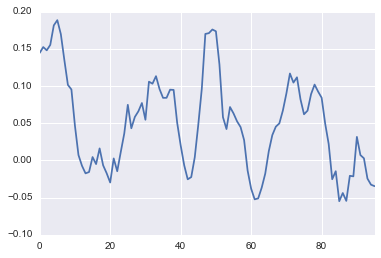

In [72]:
pd.Series(movies.sentiment[4]).plot()